In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import torch
import tqdm

from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader

from transformers import RobertaTokenizer, AdamW, get_linear_schedule_with_warmup, RobertaForSequenceClassification

import warnings

warnings.filterwarnings('ignore')

import logging

logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

In [3]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

cpu


In [4]:
train_dataset_path = "dataset/SemEval2018-T3-train-taskA_emoji.txt"
test_dataset_path = "dataset/SemEval2018-T3_gold_test_taskA_emoji.txt"

In [5]:
train_df = pd.read_csv(train_dataset_path, sep="\t")
train_df.rename(columns={"Tweet index": "index", "Label": "label", "Tweet text": "text"},
                inplace=True)

test_df = pd.read_csv(train_dataset_path, sep="\t")
test_df.rename(columns={"Tweet index": "index", "Label": "label", "Tweet text": "text"},
               inplace=True)
test_df.head()

,index,label,text
0,1,1,Sweet United Nations video. Just in time for C...
1,2,1,@mrdahl87 We are rumored to have talked to Erv...
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...
3,4,0,3 episodes left I'm dying over here
4,5,1,I can't breathe! was chosen as the most notabl...


Text(0.5, 0, 'length')

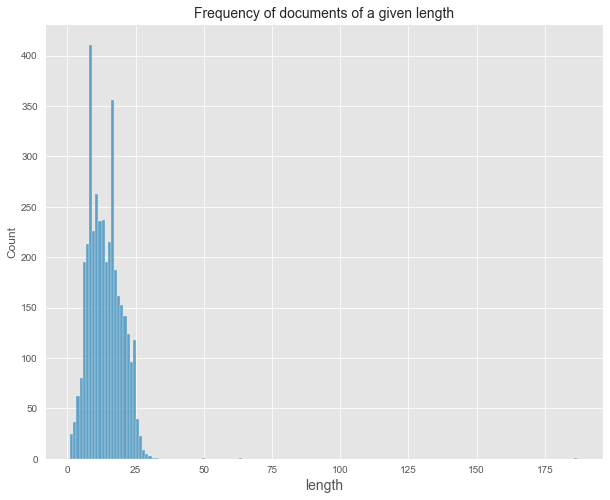

In [18]:
plt.style.use("ggplot")

plt.figure(figsize=(10, 8))
train_df["length"] = train_df["text"].apply(lambda x: len(x.split()))
sns.histplot(train_df["length"])
plt.title("Frequency of documents of a given length", fontsize=14)
plt.xlabel("length", fontsize=14)

In [6]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [7]:
train_df["text"] = train_df["text"].apply(lambda x: preprocess(x))

In [8]:
class SarcasticSentenceDataset(Dataset):
    def __init__(self, sentences, labels,
                 tokenizer: RobertaTokenizer = RobertaTokenizer.from_pretrained("roberta-base"),
                 max_len=128):
        if len(sentences) != len(labels):
            raise ValueError("Sentences and labels should have the same number of elements.")

        self.tokenizer = tokenizer
        self.sentences = sentences
        self.labels = labels
        self.max_len = max_len

    def __getitem__(self, index: int):
        inputs = self.tokenizer(self.sentences[index],
                                truncation=True,
                                pad_to_max_length=True,
                                return_tensors="pt",
                                max_length=self.max_len)

        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[index], dtype=torch.long)
        }

    def __len__(self):
        return len(self.sentences)

In [9]:
sentences = train_df["text"].tolist()
labels = train_df["label"].tolist()

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
train_dataset = SarcasticSentenceDataset(sentences=train_df["text"].tolist(),
                                         labels=train_df["label"].tolist(),
                                         tokenizer=tokenizer)

test_dataset = SarcasticSentenceDataset(sentences=test_df["text"].tolist(),
                                        labels=test_df["label"].tolist(),
                                        tokenizer=tokenizer)

In [10]:
item = train_dataset[0]
print(f"sentence: {sentences[0]}\n"
      f"ids: {item['input_ids']}\n"
      f"attention_mask: {item['attention_mask']}\n"
      f"label: {item['labels']}")

sentence: Sweet United Nations video. Just in time for Christmas. #imagine #NoReligion  http
ids: tensor([    0, 35942,   315,  3076,   569,     4,  1801,    11,    86,    13,
         1619,     4,   849,   757, 37620,   849,  3084, 29806, 43617,  1437,
         2054,     2,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,  

In [11]:
TRAIN_BATCH_SIZE = 4
EPOCHS = 2

In [12]:
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(0.2 * dataset_size))
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(train_dataset,
                          sampler=train_sampler,
                          batch_size=TRAIN_BATCH_SIZE)
validation_loader = DataLoader(train_dataset,
                               sampler=validation_sampler,
                               batch_size=TRAIN_BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=4)

In [13]:
model = RobertaForSequenceClassification.from_pretrained("roberta-base")

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

In [14]:
num_batches = len(train_dataset) // TRAIN_BATCH_SIZE
num_warmup_steps = min(4000, int(0.1 * EPOCHS * num_batches))
num_training_steps = num_batches * EPOCHS

optimizer = AdamW(model.parameters(), lr=0.00001, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=num_warmup_steps,
                                            num_training_steps=num_training_steps)

In [25]:
import copy


def train(model, optimizer, scheduler, device):
    best_f1 = 0
    best_epoch = -1
    best_params = copy.deepcopy(model.state_dict())
    patience = 0

    for epoch in range(EPOCHS):
        print(f"epoch: {epoch}")

        result = train_epoch(model, optimizer, train_loader, device)
        print(f"train loss: {result['loss']}"
              f"train accuracy: {100 * result['accuracy']}%")

        result = valid_epoch(model, device, validation_loader)
        print(f"valid accuracy: {result['accuracy']}"
              f"valid f1: {result['f1']}")

        if result["f1"] > best_f1:
            best_f1 = result["f1"]
            best_epoch = epoch
            best_params = copy.deepcopy(model.state_dict())
            patience = 0
        else:
            patience += 1

        print(f"patience: {patience}")
        if patience == 2:
            break

        best_params = copy.deepcopy(model.state_dict())
        scheduler.step()

    print(f"best epoch: {best_epoch}"
          f"best f1: {best_f1}")

    model.load_state_dict(best_params)
    result = valid_epoch(model, device, test_loader)
    print(f"test accuracy: {result['accuracy']}"
          f"test f1: {result['f1']}")

    torch.save(model.state_dict(), "model.pth")
    print("model params saved")


def train_epoch(model, optimizer, loader, device):
    model.train()

    total_loss = 0.0
    total_correct = 0
    total_examples = 0
    total_steps = 0

    for batch in tqdm.tqdm(loader):
        ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        output = model(ids, attention_mask=mask, labels=labels, return_dict=True)
        loss = output.loss
        _, preds = torch.max(output.logits, dim=1, keepdim=False)
        correct = (labels == preds).sum().item()

        total_steps += 1
        total_examples += ids.size()[0]
        total_loss += loss.item()
        total_correct += correct

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return {
        "loss": total_loss / total_steps,
        "accuracy": total_correct / total_examples
    }


def valid_epoch(model, loader, device):
    return compute_metrics(*test(model, loader, device))


def test(model, loader, device):
    model.eval()

    labels_list = []
    preds_list = []

    with torch.no_grad():
        for batch in loader:
            ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            output = model(ids, attention_mask=attention_mask, labels=labels, return_dict=True)
            _, preds = torch.max(output.logits, dim=1, keepdim=False)

            labels_list.extend(labels.cpu().numpy().tolist())
            preds_list.extend(preds.cpu().numpy().tolist())

    return labels_list, preds_list


def compute_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": confusion_matrix(y_true, y_pred)
    }

In [26]:
train(model, optimizer, test_loader, device)

KeyboardInterrupt: 